# Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

regression_days_used = 60

In [37]:

coin_file = open("../../data/raw/coinmarketcap/historical_data.json")
coin_data = json.load(coin_file)

coin_data = pd.DataFrame(coin_data["Bitcoin"])
sentiment_data_df = pd.read_json("../../data/processed/reddit_summary_all.json", orient="index")

keyword_sentiment_data = sentiment_data_df["keyword_based_sentiment"].apply(pd.Series)

Bitcoin_specific_sentiment = keyword_sentiment_data["bitcoin"].apply(pd.Series)[["count","sentiment"]].dropna()

coin_data["timestamp"] = pd.to_datetime(coin_data["timestamp"]).dt.date

Bitcoin_specific_sentiment.reset_index(inplace=True)
Bitcoin_specific_sentiment.rename(columns = {"index": 'timestamp'}, inplace=True)
Bitcoin_specific_sentiment["timestamp"] = pd.to_datetime(Bitcoin_specific_sentiment["timestamp"]).dt.date


merged_data = pd.merge(left=coin_data, right=Bitcoin_specific_sentiment, how='left', left_on='timestamp', right_on='timestamp').dropna()

merged_data.index = pd.DatetimeIndex(merged_data["timestamp"]).to_period("d")
merged_data.drop(labels = "timestamp", axis = 1, inplace=True)
#merged_data.drop(labels = ["high", "low", "close", "volume", "marketCap", "count"], axis=1, inplace=True)
merged_data.drop(labels = ["high", "low", "close", "volume", "marketCap"], axis=1, inplace=True)
merged_data.head(5)

,open,count,sentiment
timestamp,,,
2021-06-07,43273.054043,2.0,0.208
2021-06-09,40480.023706,1.0,0.495
2021-06-10,45297.585159,2.0,-0.276
2021-06-14,47443.153091,1.0,0.403
2021-06-15,49091.884823,1.0,0.000


In [3]:
coint_johansen(merged_data, -1, 1).eig

array([3.63384859e-01, 2.96991641e-02, 1.51654493e-04])

In [4]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

df_difference = merged_data.diff().diff().diff().dropna()
df_difference = df_difference[-regression_days_used:]
for name, column in df_difference.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0276
 No. Lags Chosen       = 10
 Critical value 1%     = -3.571
 Critical value 5%     = -2.923
 Critical value 10%    = -2.599
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3034
 No. Lags Chosen       = 11
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sentiment" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [18]:
#creating the train and validation set

num_obs = 7
train = df_difference[:-num_obs]

model = VAR(train)

suggested_order = model.select_order(maxlags=10)
suggested_order.summary()

,AIC,BIC,FPE,HQIC
0,27.76,27.89,1.142e+12,27.81
1,25.85,26.34,1.682e+11,26.03
2,24.30,25.16,3.613e+10,24.62
3,23.53,24.76,1.704e+10,23.99
4,23.19,24.79,1.247e+10,23.78
5,23.13,25.09,1.239e+10,23.85
6,22.96,25.29,1.136e+10,23.82
7,22.20,24.91,6.052e+09,23.20
8,22.08,25.15,6.368e+09,23.21
9,21.60,25.04,5.108e+09,22.87


In [30]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Mar, 2022
Time:                     08:33:43
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    25.7244
Nobs:                     52.0000    HQIC:                   25.4467
Log likelihood:          -866.481    FPE:                9.47981e+10
AIC:                      25.2741    Det(Omega_mle):     7.59007e+10
--------------------------------------------------------------------
Results for equation open
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               26.789983       937.895132            0.029           0.977
L1.open             -0.662035         0.108472           -6.103           0.000
L1.count           -19.514351        37.445139           -0.521  

In [31]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)


for col, val in zip(train.columns, out):
    print(col, ':', round(val, 2))


open : 2.67
count : 2.69
sentiment : 2.64


In [33]:
lag_order = results.k_ar

print("LAG ORDER IS: {} ".format(lag_order))

forecasting_input = df_difference.values[-lag_order:]


fc = results.forecast(forecasting_input, steps=num_obs)

print(df_difference.index[-1])

idx = pd.date_range(str(df_difference.index[-1]), periods=num_obs, freq='D')

df_forecast = pd.DataFrame(fc, index=idx, columns=df_difference.columns + '_2d')

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(merged_data[-regression_days_used:], df_forecast, second_diff=True)    
df_results.drop(["open_2d", "open_1d", "sentiment_1d", "sentiment_2d"], axis=1, inplace=True)
print(df_results)

LAG ORDER IS: 1 
2022-03-25
              count_2d  open_forecast   count_1d  count_forecast  \
2022-03-25  -29.865924   55911.360337 -34.865924      200.134076   
2022-03-26   91.830976   58195.033541  56.965052      257.099129   
2022-03-27 -127.860903   57253.613917 -70.895851      186.203278   
2022-03-28  145.070990   61421.814032  74.175139      260.378417   
2022-03-29 -152.472240   59000.257114 -78.297101      182.081317   
2022-03-30  151.743273   64301.538818  73.446172      255.527488   
2022-03-31 -148.216197   61230.572262 -74.770025      180.757464   

            sentiment_forecast  
2022-03-25           33.344964  
2022-03-26           32.793411  
2022-03-27           48.545545  
2022-03-28           49.786163  
2022-03-29           63.923278  
2022-03-30           66.349980  
2022-03-31           79.331399  


In [34]:
print(merged_data[-num_obs:])

forecasts = df_results[["open_forecast", "sentiment_forecast"]]
print(forecasts)

                    open  count  sentiment
timestamp                                 
2022-03-19  52682.153595   74.0      4.695
2022-03-20  53182.477353   91.0      8.015
2022-03-21  51996.731145  106.0      5.327
2022-03-22  51707.943734  133.0      8.400
2022-03-23  53308.367835  181.0      7.867
2022-03-24  53864.050890  240.0     18.571
2022-03-25  55047.920399  235.0     15.178
            open_forecast  sentiment_forecast
2022-03-25   55911.360337           33.344964
2022-03-26   58195.033541           32.793411
2022-03-27   57253.613917           48.545545
2022-03-28   61421.814032           49.786163
2022-03-29   59000.257114           63.923278
2022-03-30   64301.538818           66.349980
2022-03-31   61230.572262           79.331399


2022-03-25    55911.360337
2022-03-26    58195.033541
2022-03-27    57253.613917
2022-03-28    61421.814032
2022-03-29    59000.257114
2022-03-30    64301.538818
2022-03-31    61230.572262
Freq: D, Name: open_forecast, dtype: float64


<AxesSubplot:xlabel='timestamp'>

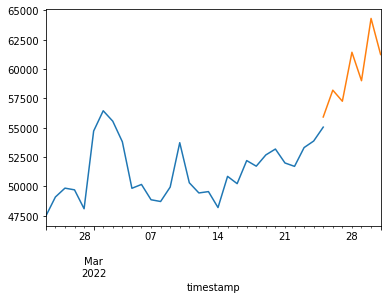

In [36]:

forecast_data = forecasts["open_forecast"]
actual_data = merged_data[-30:]["open"]

print(forecast_data)

actual_data.plot(y="open")
forecast_data.plot(y="open_forecast")